# Retrieval evaluation with query expansion



### Built on the retrieval_evaluation repository. Consult the [readme](https://github.com/michaelprem/retrieval_evaluation/blob/master/README.md) of that repository for prerequisites.

### In addition (pip) install:  (if not installed already):

- pyenchant - a dictionary to consult for finding "real" English words, 
- wget for dowloading model files from the internet
- bz2 for decompressing compressed file
- shutil for saving decompressed files.
- gensim for word2vec models

The repository tests two types of query expansion:

- expand_wn(): based om wordnet synomyms (using the NLTK package)
- expand_w2v() based on embeddings: word2vec models (using the gensim package and downloaded embeddings). This takes about 15-20 minutes of file downloading and model loading first time a model is used, but repeated tests can be done on a loaded model. 



In [3]:
pip install wget

You are using pip version 19.0.2, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### We start with a test of the pytrec_eval utility

In [4]:
import pytrec_eval 
import json
##Qrel is the assignment (pre judging) of relevant documents to queries, the "facit"
qrel = {
    'q1': {
        'd1': 0,
        'd2': 1,
        'd3': 0,
    },
    'q2': {
        'd2': 1,
        'd3': 1,
    },}

run = {
    'q1': {
        'd1': 1.0,
        'd2': 0.0,
        'd3': 1.5,
    },
    'q2': {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
    }
}

evaluator = pytrec_eval.RelevanceEvaluator(
    qrel, {'map_cut', 'ndcg_cut', 'iprec_at_recall', 'recall'})

print(json.dumps(evaluator.evaluate(run), indent=1))

{
 "q1": {
  "iprec_at_recall_0.00": 0.3333333333333333,
  "iprec_at_recall_0.10": 0.3333333333333333,
  "iprec_at_recall_0.20": 0.3333333333333333,
  "iprec_at_recall_0.30": 0.3333333333333333,
  "iprec_at_recall_0.40": 0.3333333333333333,
  "iprec_at_recall_0.50": 0.3333333333333333,
  "iprec_at_recall_0.60": 0.3333333333333333,
  "iprec_at_recall_0.70": 0.3333333333333333,
  "iprec_at_recall_0.80": 0.3333333333333333,
  "iprec_at_recall_0.90": 0.3333333333333333,
  "iprec_at_recall_1.00": 0.3333333333333333,
  "recall_5": 1.0,
  "recall_10": 1.0,
  "recall_15": 1.0,
  "recall_20": 1.0,
  "recall_30": 1.0,
  "recall_100": 1.0,
  "recall_200": 1.0,
  "recall_500": 1.0,
  "recall_1000": 1.0,
  "ndcg_cut_5": 0.5,
  "ndcg_cut_10": 0.5,
  "ndcg_cut_15": 0.5,
  "ndcg_cut_20": 0.5,
  "ndcg_cut_30": 0.5,
  "ndcg_cut_100": 0.5,
  "ndcg_cut_200": 0.5,
  "ndcg_cut_500": 0.5,
  "ndcg_cut_1000": 0.5,
  "map_cut_5": 0.3333333333333333,
  "map_cut_10": 0.3333333333333333,
  "map_cut_15": 0.33333333

# We define classes that facilitates precision-recall curves with matplotlib

In [5]:

import re
import json

#<h2>THe NLTK-package is rich in facilities for all sorts of natural language processing, among othes Information Retrieval.</h2>

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import sys
import codecs
from elasticsearch import Elasticsearch, ElasticsearchException, SerializationError,TransportError
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pprint import pprint


class PRCurve:
    REC_ARR=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    def __init__(self, label,  precarr, linestyle=None, color=None):
        #self.plt=plt
        self.label=label
        self.precarr=list(precarr)
        self.linestyle=linestyle
        self.color=color
        self.ydata=[]
        self.l2d=None
    
    def mp_plot(self, linestyle=None, color=None):
        if linestyle==None and color==None:
            self.l2d =plt.plot(self.REC_ARR, self.precarr, label=self.label)[0]
        else:
            self.l2d =plt.plot(x=self.REC_ARR, y=self.precarr, label=self.label, linestyle=linestyle, color=color)[0]
        return self.l2d

class CurveWithLabel:
    REC_ARR=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    def __init__(self, averages, name):
        #self.plt=plt
        self.name=name
        self.averages=averages
        self.summary_measures=self.extract()
        self.label=self.make_label()
        #self.l2d=self.mp_plot()
        
    def extract(self):
        summary_measures=dict()
        print("self.averages:",self.averages)
        for ky in list(self.averages.keys()):
            if 'iprec' not in ky:
                
                summary_measures.update({ky : self.averages[ky]})
                _=self.averages.pop(ky)
                
        return summary_measures
    
    def make_label(self):
        ret=self.name+":"
        for ky in self.summary_measures:
            val=self.summary_measures[ky]
            ret += " " + ky + "=" + str(val)[0:5] +","
        ret=ret.strip(',')    
        return ret
    
    def mp_plot(self, linestyle=None, color=None):
        p=PRCurve(self.label, self.averages.values(), linestyle=linestyle, color=color)
        p.mp_plot(linestyle=linestyle, color=color)
        return p.l2d
        



In [7]:
import string
import enchant #Dictionary lookup
from nltk.corpus import wordnet
from nltk.tokenize import  word_tokenize
from nltk.corpus import stopwords
from os import path
import bz2, shutil
import wget

from gensim.models import KeyedVectors
stop_words=set(stopwords.words("english"))


def expand_wn(querydict, include_original=False, stopwords=True, n_exp=2):
    expanded_querydict=dict()
    for qnr in querydict:
        query=querydict[qnr]
        expanded_query=''
        query=query.lower()
        query=query.translate(str.maketrans('','',string.punctuation))
        word_tokens = word_tokenize(query)
        filtered_sentence=[]
        if stopwords:
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
        else:
            filtered_sentence = [w for w in word_tokens]

        synonyms=set()
        if include_original:
            for t in filtered_sentence:
                synonyms.add(t)

        count=0
        for x in filtered_sentence:

            for syn in wordnet.synsets(x):
                for l in syn.lemmas() :
                    if(count<n_exp):
                        if l.name() not in synonyms:
                            synonyms.add(l.name())
                            count+=1

            count=0
        
        new_query=' '.join(list(synonyms))
        expanded_querydict[qnr]=new_query

    return expanded_querydict

def expand_w2v(querydict, include_original=False, stopwords=True, model=None, topn=3):

    """
    Expand with pretrained embeddings downloaded from wikipedia (english, 100 dimensions)
    See here: 
        https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ 
    for other models.
    Model can be re-used within a session
    """
    
    if model is None:
        url = "http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2"
        start=url.rfind('/')+1
        end=url.rfind('.bz2')
        filename=url[start:end]
        if not path.exists(filename):
            wget.download(url)
            import bz2,shutil
    
        url = "http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2"
        start=url.rfind('/')+1
        end=url.rfind('.bz2')
        filename=url[start:end]
        if not path.exists(filename):
            wget.download(url)
            with bz2.BZ2File(filename+".bz2") as fr, open(filename,"wb") as fw:
                shutil.copyfileobj(fr,fw)
                model=KeyedVectors.load_word2vec_format(filename)
    
    expanded_querydict=dict()
    for qnr in querydict:
        query=querydict[qnr]
        expanded_query=''
        query=query.lower()
        query=query.translate(str.maketrans('','',string.punctuation))
        word_tokens = word_tokenize(query)
        filtered_sentence=[]
        if stopwords:
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
        else:
            filtered_sentence = [w for w in word_tokens]
        
        synonyms=set()
        if include_original:
            for t in filtered_sentence:
                synonyms.add(t)

        """ 
        Find the most similar words that match dictionary entries
        """
        d = enchant.Dict("en_US")        
        for x in filtered_sentence:
            #returns a list of tuples
            count=0
            for tpl in model.most_similar(x, topn=topn*3): # allow for skipping 
                                                           # non-dictionary words
                if count==topn:
                    break
                w=tpl[0]
                
                """Only use words that appear in a dictionary"""
                if  d.check(w):
                    synonyms.add(w)
                    count+=1
                    
        
        new_query=' '.join(list(synonyms))
        expanded_querydict[qnr]=new_query

    return expanded_querydict, model


## Index settings (e.g. similarity function)

In [8]:
#WE ARE USING THE CLUEWEB09 INDEX WITH 50 mill web pages as documents        
INDEX_NAME = "clueweb"  # the name of the index
DOC_TYPE = "html"  # we have a single type of document, so it doesn't matter
REMOVE_STOPWORDS=True
STEM=False
#We build a JSON Configuration document for accessing Elasticsearch
#   see here: https://www.elastic.co/guide/en/elasticsearch/reference/7.5/index-modules-similarity.html#scripted_similarity
#   about changing the similarity function
### changing tfidf calc: see "scripted similarity"

INDEX_SETTINGS = {  # two shards with a single replica
    "settings" : {
        "index" : {
            "number_of_shards" : 6,
            "number_of_replicas" : 1
           #,"similarity" : { "default" : { "type" : "LMJelinekMercer", "lambda":"0.4" }
            }
        }
        ,
    "mappings": {
            "html": {
            "properties": {
#                "post_date": { "type": "date" }
#                ,
                "title": {"type": "text" }
                ,
#                "id": { "type": "keyword"}
#                ,
                "text": { "type": "text" }
                ,
                "description": {"type": "text"}
                ,
                "keywords": {"type": "keyword"}
                ,
                "classification":{"type": "text"}
                }
            }
        }
    }

### Utility functions

In [9]:
import pytrec_eval
from os import path
import sys
import json
import matplotlib.patches as mpatches
es = Elasticsearch("localhost:9200", log="trace", timeout=1000)
print(es)

def run_expanded(
        querydict,
        es=es, 
        index="clueweb", 
        similarity="DFR", 
        parameterNames=["basic_model", "after_effect", "normalization", "normalization.h2.c"], 
        parameterValues=["g",          "l",            "h2", "4.0"]
        ):
    es.indices.close(index=index)
    val_dict={"type":similarity}
    for i in range(len(parameterNames)):
        val_dict[parameterNames[i]]=parameterValues[i]
        
    print("val_dict=", val_dict)
    def_dict={"default":val_dict}
    sim_dict= {"similarity": def_dict}
    setting_dict={"index":sim_dict}
    similarity_setting=json.JSONEncoder().encode(setting_dict)
    print("setting1", similarity_setting)
    es.indices.put_settings(index=index, body=similarity_setting)
    #HERE WE REOPEN THE INDEX - READY FOR RETRIEVAL
    es.indices.open(index=index)
    es.indices.refresh(index=index)


    qrels=dict()
    with open("qrels.adhoc", 'r') as myfile: #, errors='replace'
            qrel_lines=myfile.readlines()

    for line in qrel_lines:
        qnr, zero, docnr, rel=line.split()
        if qnr not in qrels.keys():
            qrels[qnr]=dict()
        qrels[qnr][docnr]=int(rel)

    queries=querydict

    run=dict()    
    for qr in queries.keys():
        query=queries[qr]
        res = es.search(index=INDEX_NAME, q=query, _source=False, size=1000)
        for hit in res['hits']['hits']:
    #        print("Doc ID: %3r  Score: %5.2f" % (hit['_id'], hit['_score']))
            if qr not in run.keys():
                run[qr]=dict()
            run[qr][hit['_id']]=hit['_score']    

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrels, { 'iprec_at_recall', 'map', 'ndcg',  'recall'}) #, 'map', 'ndcg',
    eval=evaluator.evaluate(run)


    avres=dict()

    for q in eval.keys():

        for res in eval[q].keys():
            if "recall" in res and "iprec" not in res and "1000" not in res:
                continue

            if res not in avres.keys():
                avres[res]=0 #initialize
            avres[res]+=eval[q][res]/len(eval)#update average
        
    return avres

def run(es=es, 
        index="clueweb", 
        queryfile="q156-160_brief.txt",
        similarity="DFR", 
        parameterNames=["basic_model", "after_effect", "normalization", "normalization.h2.c"], 
        parameterValues=["g",          "l",            "h2", "4.0"]
       ):
    
    #HERE WE CLOSE THE INDEX SO THAT WE CAN OPERATE ON IT
    es.indices.close(index=index)
    val_dict={"type":similarity}
    for i in range(len(parameterNames)):
        val_dict[parameterNames[i]]=parameterValues[i]
        
    print("val_dict=", val_dict)
    def_dict={"default":val_dict}
    sim_dict= {"similarity": def_dict}
    setting_dict={"index":sim_dict}
    similarity_setting=json.JSONEncoder().encode(setting_dict)
    print("setting1", similarity_setting)
    es.indices.put_settings(index=index, body=similarity_setting)

    #HERE WE REOPEN THE INDEX - READY FOR RETRIEVAL
    es.indices.open(index=index)
    es.indices.refresh(index=index)


    qrels=dict()
    with open("qrels.adhoc", 'r') as myfile: #, errors='replace'
            qrel_lines=myfile.readlines()

    for line in qrel_lines:
        qnr, zero, docnr, rel=line.split()
        if qnr not in qrels.keys():
            qrels[qnr]=dict()
        qrels[qnr][docnr]=int(rel)

    queries=dict()
    with open(queryfile) as qfile:
        qlines=qfile.readlines()

    for line in qlines:
        qnr, qstring=line.split(':')
        qstring=qstring.strip('\n')
        if qnr not in queries.keys():
            queries[qnr]=qstring

    run=dict()    
    for qr in queries.keys():
        query=queries[qr]
        res = es.search(index=INDEX_NAME, q=query, _source=False, size=1000)
        for hit in res['hits']['hits']:
    #        print("Doc ID: %3r  Score: %5.2f" % (hit['_id'], hit['_score']))
            if qr not in run.keys():
                run[qr]=dict()
            run[qr][hit['_id']]=hit['_score']    

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrels, { 'iprec_at_recall', 'map', 'ndcg', 'recall'}) #, 'map', 'ndcg',
    eval=evaluator.evaluate(run)


    avres=dict()

    for q in eval.keys():

        for res in eval[q].keys():
            if "recall" in res and "iprec" not in res and "1000" not in res:
                continue

            if res not in avres.keys():
                avres[res]=0 #initialize
            avres[res]+=eval[q][res]/len(eval)#update average
        
    return avres, queries

def plotCombined(cwls):
    colors=['red', 'aqua', 'darkmagenta', 'sienna', 'brown', 'grey']
    linestyles=['-', '--', '-.', '.', ':', '-' ]
    l2ds=list()
    ax=None
    for c in range(len(cwls)):
        cwl=cwls[c]
        ls=linestyles[c]
        color=colors[c]
       
        l2ds.append(cwl.mp_plot())
        
    #ax.legend(l2ds, labels)
    plt.legend()
    plt.show()
    #plt.gcf().clear()

curvesWithLabels=list()

<Elasticsearch([{'host': 'localhost', 'port': 9200}])>


## running and plotting

val_dict= {'type': 'classic'}
setting1 {"index": {"similarity": {"default": {"type": "classic"}}}}
self.averages: {'map': 0.016612296444831386, 'iprec_at_recall_0.00': 0.42874909060516786, 'iprec_at_recall_0.10': 0.03549275675919892, 'iprec_at_recall_0.20': 0.018126724477729603, 'iprec_at_recall_0.30': 0.0, 'iprec_at_recall_0.40': 0.0, 'iprec_at_recall_0.50': 0.0, 'iprec_at_recall_0.60': 0.0, 'iprec_at_recall_0.70': 0.0, 'iprec_at_recall_0.80': 0.0, 'iprec_at_recall_0.90': 0.0, 'iprec_at_recall_1.00': 0.0, 'recall_1000': 0.16325944732358982, 'ndcg': 0.08790952279897163}


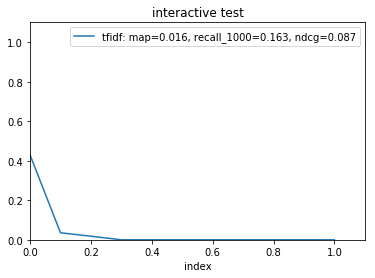

In [10]:
import struct
import sys
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
curvesWithLabels=list()

plt.ion() #Turn on interactive mode
plt.axis([0,1.1, 0,1.1])
plt.title("interactive test")
plt.xlabel("index")
#        similarity="DFR", 
#        parameterNames=["basic_model", "after_effect", "normalization", "normalization.h2.c"], 
#        parameterValues=["g",          "l",            "h2", "4.0"]

avres, querydict = run(es, similarity="classic", queryfile="q156-160_full.txt",  parameterNames=[], parameterValues=[])

tfidf=CurveWithLabel(avres, "tfidf")
curvesWithLabels.append(tfidf)
plotCombined(curvesWithLabels)

#lm=Curve(plt, "lm", [.35, 0.3, 0.29, .285, .24, .22, 0.21, .118, .116, .114, 0.0] )
#lm.mp_plot()
#plt.ylabel("ylb")
#plt.legend()

In [11]:
querydict

{'156': 'online programs are offered by the University of Phoenix',
 '157': 'What is the history of the Beatles rock band listing songs',
 '158': 'alternatives are there for the design of a septic system',
 '159': 'K-12 schools are in Porterville colleges or post-secondary medical care',
 '160': 'Find tips on grilling fish instructions chicken'}

## Example expanding with wordnet synonyms

val_dict= {'type': 'classic'}
setting1 {"index": {"similarity": {"default": {"type": "classic"}}}}
self.averages: {'map': 0.009017579743767937, 'iprec_at_recall_0.00': 0.21853318912142441, 'iprec_at_recall_0.10': 0.033567354932340095, 'iprec_at_recall_0.20': 0.0286722500372352, 'iprec_at_recall_0.30': 0.013268608414239482, 'iprec_at_recall_0.40': 0.0, 'iprec_at_recall_0.50': 0.0, 'iprec_at_recall_0.60': 0.0, 'iprec_at_recall_0.70': 0.0, 'iprec_at_recall_0.80': 0.0, 'iprec_at_recall_0.90': 0.0, 'iprec_at_recall_1.00': 0.0, 'recall_1000': 0.17713931824478743, 'ndcg': 0.08064021375396586}


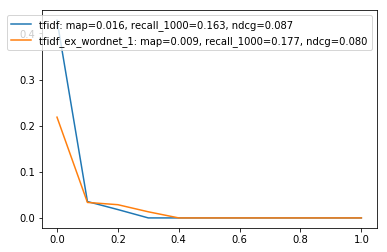

In [12]:
"""
How many terms should we expand with
"""
n_exp=1

expanded_querydict=expand_wn(querydict, include_original=True, stopwords=True, n_exp=n_exp)
avres=run_expanded(expanded_querydict, es, similarity="classic",  parameterNames=[], parameterValues=[])

tfidf_long=CurveWithLabel(avres, "tfidf_ex_wordnet_"+str(n_exp))
curvesWithLabels.append(tfidf_long)
plotCombined(curvesWithLabels)

In [13]:
expanded_querydict

{'156': 'offered online programs phoenix on-line offer plan Phoenix university',
 '157': 'song band beatles listing list Beatles stone history rock account set songs',
 '158': 'system septic scheme option alternatives designing design infected',
 '159': 'postsecondary medical care school k12 colleges attention schools porterville college checkup',
 '160': 'tips instruction_manual Pisces poulet chicken broil tip discovery instructions fish find grilling'}

## Example embedding with similarity in word2vec embeddings

val_dict= {'type': 'classic'}
setting1 {"index": {"similarity": {"default": {"type": "classic"}}}}
self.averages: {'map': 0.016714840801075808, 'iprec_at_recall_0.00': 0.24906120023767084, 'iprec_at_recall_0.10': 0.0440530303030303, 'iprec_at_recall_0.20': 0.0397442084942085, 'iprec_at_recall_0.30': 0.02437673130193906, 'iprec_at_recall_0.40': 0.021906693711967545, 'iprec_at_recall_0.50': 0.0, 'iprec_at_recall_0.60': 0.0, 'iprec_at_recall_0.70': 0.0, 'iprec_at_recall_0.80': 0.0, 'iprec_at_recall_0.90': 0.0, 'iprec_at_recall_1.00': 0.0, 'recall_1000': 0.18044563384126427, 'ndcg': 0.08402732817930486}


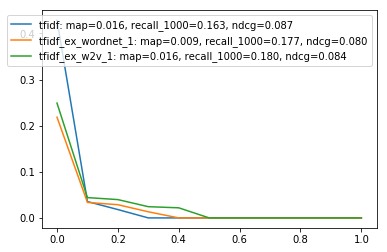

In [15]:
"""
How many terms should we expand with
"""
n_exp=1

"""
At start, model does not exist. Set to None to load a new one
Avoid re-loading if model exist and re-used, as it takes long time to load.
"""
# model =None
try:
    model
except NameError:
    model = None
    
# uncomment to set model to None if you wish to load a new model
if model is not None:
    expanded_querydict, model=expand_w2v(querydict, include_original=True, stopwords=True, model=model, topn=n_exp)
else:
    expanded_querydict, model=expand_w2v(querydict, include_original=True, stopwords=True, topn=3)
avres=run_expanded(expanded_querydict, es, similarity="classic",  parameterNames=[], parameterValues=[])

tfidf_long=CurveWithLabel(avres, "tfidf_ex_w2v_"+str(n_exp))
curvesWithLabels.append(tfidf_long)
plotCombined(curvesWithLabels)

In [16]:
expanded_querydict

{'156': 'offered online programs phoenix offer program college university',
 '157': 'band bands beatles listing renditions history rock histories songs lists',
 '158': 'systems system septic options alternatives design designs',
 '159': 'postsecondary health medical care veterinary k12 colleges schools porterville universities',
 '160': 'tips sautéing discover chicken instruction beef instructions fish find grilling shrimp'}